### __Imports and installs__

In [1]:
from pathlib import Path
import subprocess
import requests
from tqdm import tqdm

import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as T

from utils_dataset import CustomImageDataset, deprocess_image, load_labels
from utils_plot import show_images, show_one_image, show_cams, show_one_cam, show_centers
from utils_cam import generate_cams
from utils_models import load_model, evaluate_model_accuracy
from utils_adversarial import APD, save_adversarial_images



In [2]:
gpu_id = 0
device = torch.device(f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### __Dataset__

In [3]:
squeezenet = load_model("squeezenet")
resnet50 = load_model("resnet50")
inception_v4 = load_model("inception_v4")
adv_inception_v3 = load_model("adv_inception_v3")

models = [squeezenet, resnet50, inception_v4, adv_inception_v3]

Loading model 'squeezenet' from Model/squeezenet.pth
Loading model 'resnet50' from Model/resnet50.pth
Loading model 'inception_v4' from Model/inception_v4.pth
Loading model 'adv_inception_v3' from Model/adv_inception_v3.pth


In [4]:
images_folder_path = Path('tf_to_pytorch_model/dataset/images')
label_file_path = Path('tf_to_pytorch_model/dataset/dev_dataset.csv')

# Check if the images folder exists; if not, clone the repository
if not images_folder_path.exists():
    repo_url = 'https://github.com/ylhz/tf_to_pytorch_model.git'
    try:
        subprocess.run(["git", "clone", repo_url], check=True)
        print(f"Repository cloned successfully.")
    except subprocess.CalledProcessError as e:
        print(f"Failed to clone repository: {e}")


Labels not found locally. Downloading from https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json and saving...
Labels saved to imagenet_class_index.json


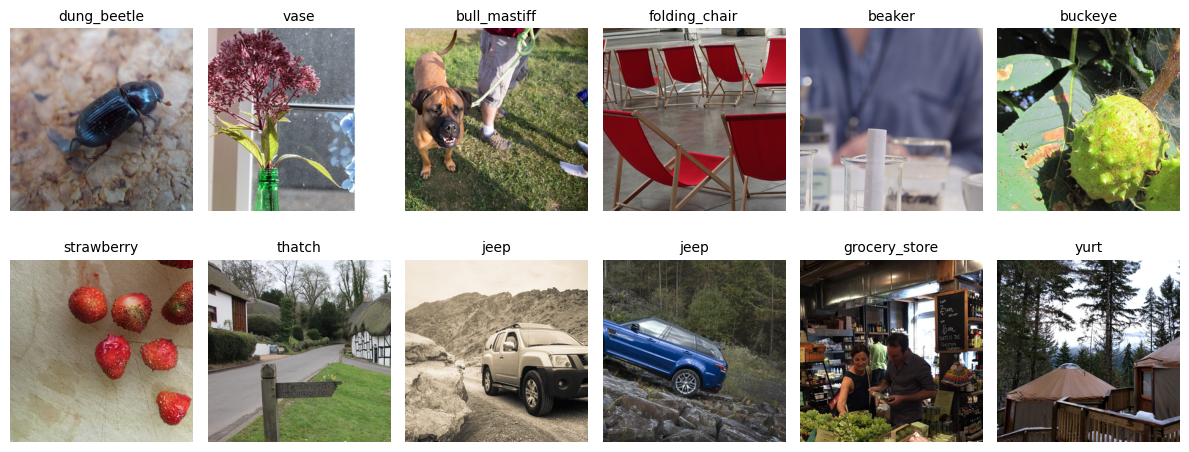

In [5]:
labels_dict = load_labels()

dataset = CustomImageDataset(label_file_path, images_folder_path)

batch_size = 24
num_workers = 4 
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

# Show some images from the dataset
images, labels, _ = next(iter(dataloader))
show_images(images, labels, labels_dict)

In [ ]:
# for model in models:
#     evaluate_model_accuracy(model, dataloader, device)

### __Class Activation Maps__

In [ ]:
# Show grad cams for some images for each model
data_iter = iter(dataloader)
images, labels, _ = next(data_iter)
images, labels, _ = next(data_iter)

# for model in models:
#     model.to(device)
#     show_cams(model, images, labels, labels_dict, rows=4, image_weight=0.6)
#     model.to('cpu')


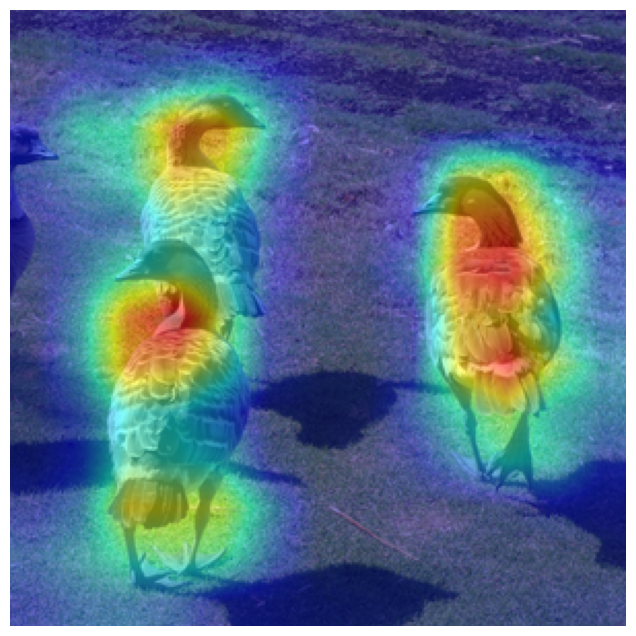

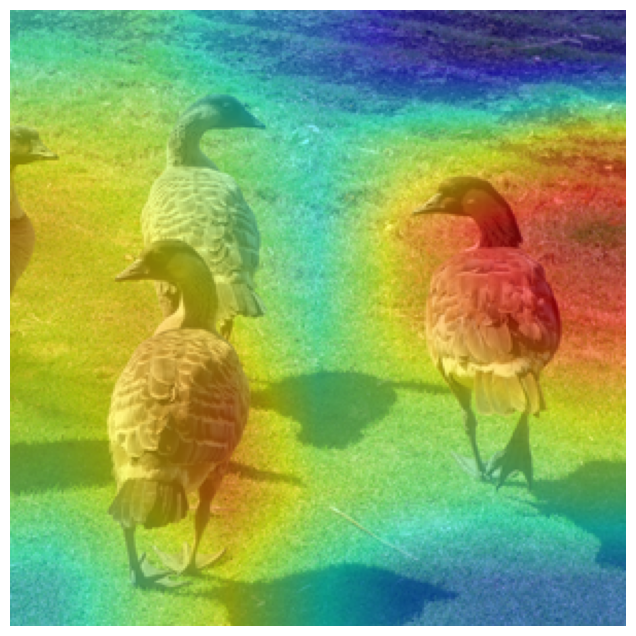

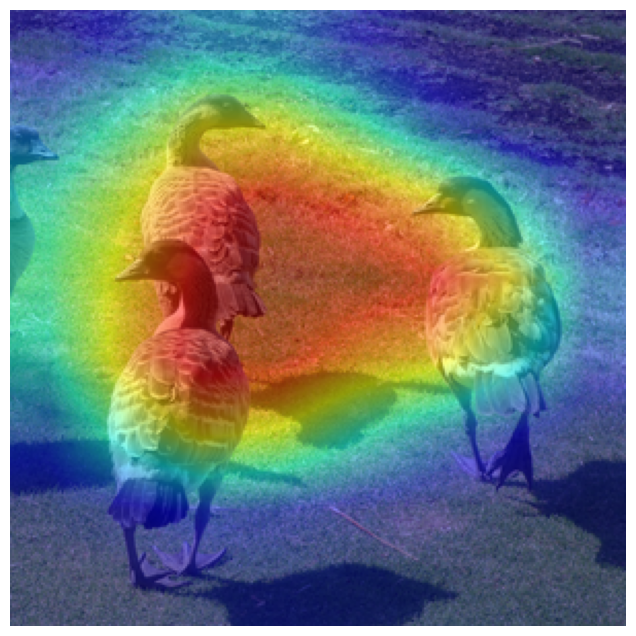

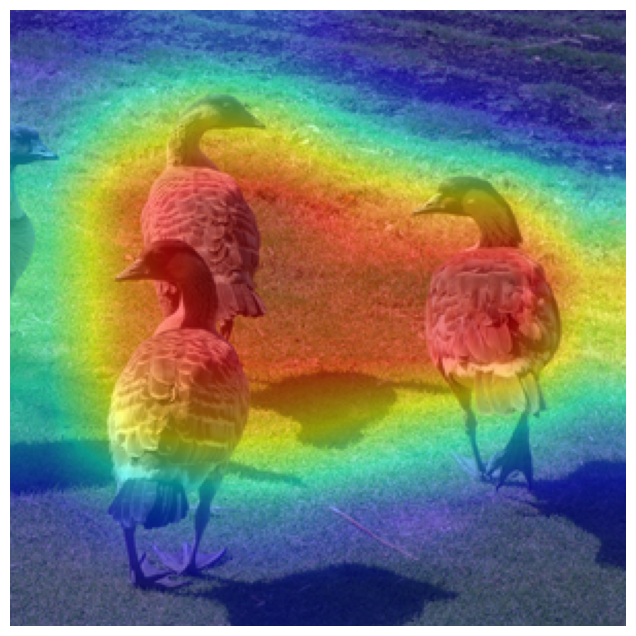

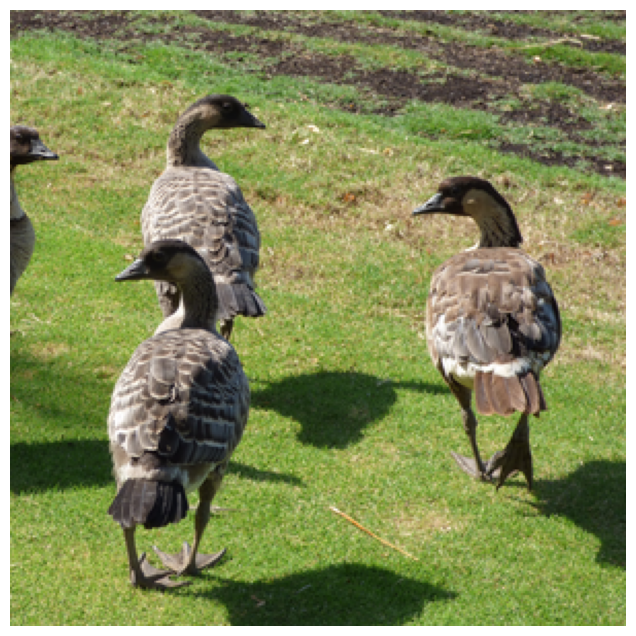

In [ ]:
idx = 5
for model in models:
    show_one_cam(model, images[idx], labels[idx], image_weight=0.5)
show_one_image(images[idx])

### __Local Maxima__

In [ ]:
images, labels, _ = next(iter(dataloader))

# for model in models:
#     show_centers(model, images, labels)

### __Main algorithm__

#### Example use

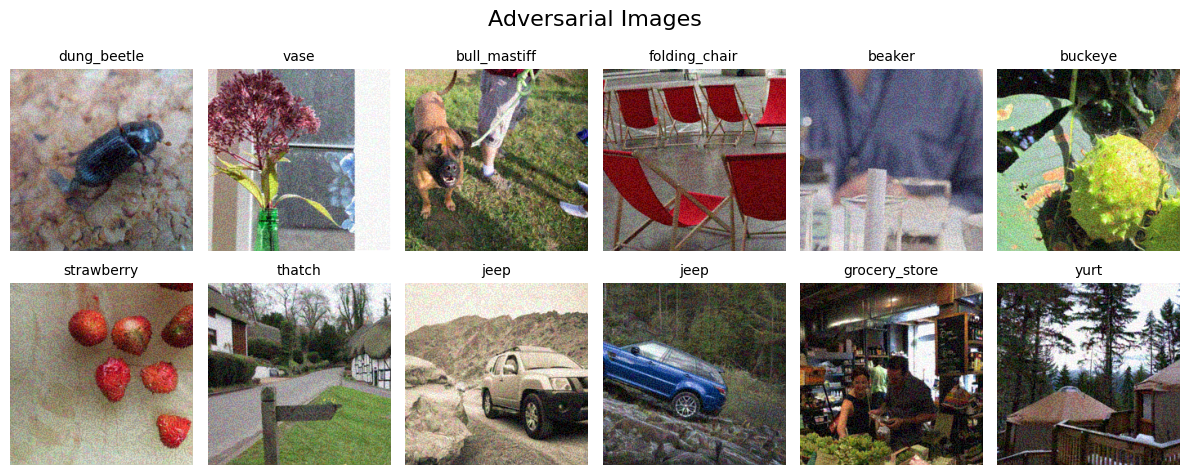

In [ ]:
images, labels, _ = next(iter(dataloader))
model = squeezenet

model.to(device)
x_adv = APD(images, labels, model)
model.to('cpu')

x_adv_dep = deprocess_image(x_adv)

show_images(x_adv_dep, labels, labels_dict, title="Adversarial Images")

In [ ]:
for model in models:
    save_adversarial_images(dataloader, model, device=device, save_dir=f"{model.name}_adv")

Generating adversarial images:  52%|█████▏    | 22/42 [09:42<08:49, 26.48s/it]


KeyboardInterrupt: 

In [ ]:
x_clean = Preprocessing_Transform(mean, std, "squeezenet", "cpu")(X[4]).unsqueeze(0)
y_true = one_hot_y[4]

x_adv = APD(x_clean, y_true, "squeezenet", squeezenet_cpu, ratio_threshold=0.6, min_distance=20, eps=0.274, T=10, alpha=0.5, beta=15, m=5, mean=mean, std=std, cam_method = "++", momentum = 0.8, device = "cpu", use_zero_gradient_method = True, replace_method = "square")
#x_adv = MFGSM(x_clean, y_true, "squeezenet", squeezenet_cpu, eps=0.274, T=50, alpha=0.5, mean=mean, std=std, momentum=0.8, device="cpu")

In [ ]:
transfer_x_adv = Preprocessing_Transform(mean, std, "inceptionv4", "cpu")(Depreprocessing_Transform(mean, std, "squeezenet")(x_adv.squeeze()))

In [ ]:
y_pred_squeezenet_before = torch.argmax(torch.nn.functional.softmax(squeezenet_cpu(x_clean)[0], dim=0))
y_pred_inceptionv4_before = torch.argmax(torch.nn.functional.softmax(inceptionv4_cpu(x_clean)[0], dim=0))

y_pred_squeezenet_after = torch.argmax(torch.nn.functional.softmax(squeezenet_cpu(x_adv)[0], dim=0))
y_pred_inceptionv4_after = torch.argmax(torch.nn.functional.softmax(inceptionv4_cpu(transfer_x_adv.unsqueeze(0))[0], dim=0))

print("True class: ", labels_dict[str(int(torch.argmax(one_hot_y[4])))][1])

print("Initial predicted class, Attack model: ", labels_dict[str(int(y_pred_squeezenet_before))][1])
print("Initial predicted class, Transfer model: ", labels_dict[str(int(y_pred_inceptionv4_before))][1])

print("New predicted class, Attack model: ", labels_dict[str(int(y_pred_squeezenet_after))][1])
print("New predicted class, Transfer model: ", labels_dict[str(int(y_pred_inceptionv4_after))][1])

### __Statistics__

In [ ]:
def get_accuracy(model, dataset_X, dataset_y):

  with torch.no_grad():
    y_pred = np.array(model(dataset_X).argmax(dim=1).detach().cpu())
  accuracy = np.mean((y_pred == dataset_y))

  return accuracy


TODO : clamp avec bonnes valeurs et adapter eps en conséquence (done!);, Essayer moyenner x_adv sur différents modèles !!
IDEES AMELIO : rescale dans algo (done), gradCAM (RDFIA) en + de gradCAM++ (done); threshold au lieu de région carrée pour régions dropout (done), tester en mettant le gradient à 0 dans les régions dropped out (done)

In [ ]:
X_adv_squeezenet = []

with torch.no_grad():
  input_dataset = Preprocessing_Transform(mean, std, "squeezenet", "cuda")(X)

squeezenet_cuda = get_model("squeezenet", "cuda")

for i in tqdm(range(len(X))):
    x_clean = input_dataset[i].unsqueeze(0)

    y_true = one_hot_y[i]

    # Generate the adversarial example
    x_adv = ADP(x_clean, y_true, "squeezenet", squeezenet_cuda, ratio_threshold=0.6, min_distance=20, eps=0.274,
                T=10, alpha=0.5, beta=15, m=5, mean=mean, std=std, cam_method="++", momentum=0.8, device = "cuda")


    X_adv_squeezenet.append(x_adv.squeeze())

X_adv_squeezenet_tensor = torch.stack(X_adv_squeezenet)

del input_dataset
del squeezenet_cuda

In [ ]:
squeezenet_cuda = get_model("squeezenet", "cuda")
with torch.no_grad():
  input_dataset = Preprocessing_Transform(mean, std, "squeezenet", "cuda")(X)
print("Initial accuracy Squeezenet: ", get_accuracy(squeezenet_cuda, input_dataset, y))
print("New accuracy Squeezenet: ", get_accuracy(squeezenet_cuda, X_adv_squeezenet_tensor, y))
del squeezenet_cuda
del input_dataset

In [ ]:
resnet50_cuda = get_model("resnet50", "cuda")
with torch.no_grad():
  input_dataset_initial = Preprocessing_Transform(mean, std, "resnet50", "cuda")(X)
  input_dataset_new = Preprocessing_Transform(mean, std, "resnet50", "cuda")(Depreprocessing_Transform(mean, std, "squeezenet")(X_adv_squeezenet_tensor))
print("Initial accuracy Resnet50: ", get_accuracy(resnet50_cuda, input_dataset_initial, y))
print("New accuracy Resnet50: ", get_accuracy(resnet50_cuda, input_dataset_new, y))
del resnet50_cuda
del input_dataset_initial
del input_dataset_new

In [ ]:
with torch.no_grad():
  input_dataset_initial = Preprocessing_Transform(mean, std, "inceptionv4", "cpu")(X)
  input_dataset_new = Preprocessing_Transform(mean, std, "inceptionv4", "cpu")(Depreprocessing_Transform(mean, std, "squeezenet")(X_adv_squeezenet_tensor))
print("Initial accuracy InceptionV4: ", get_accuracy(inceptionv4_cpu, input_dataset_initial, y))
print("New accuracy InceptionV4: ", get_accuracy(inceptionv4_cpu, input_dataset_new, y))
del input_dataset_initial
del input_dataset_new

In [ ]:
with torch.no_grad():
  input_dataset_initial = Preprocessing_Transform(mean, std, "adv_inceptionv3", "cpu")(X)
  input_dataset_new = Preprocessing_Transform(mean, std, "adv_inceptionv3", "cpu")(Depreprocessing_Transform(mean, std, "squeezenet")(X_adv_squeezenet_tensor))
print("Initial accuracy AdvInceptionV3: ", get_accuracy(adv_inceptionv3_cpu, input_dataset_initial, y))
print("New accuracy AdvInceptionV3: ", get_accuracy(adv_inceptionv3_cpu, input_dataset_new, y))
del input_dataset_initial
del input_dataset_new